# Baseline removal and Centroid measurement

Author: Charles Le Losq

This notebook illustrates the use of the `rampy.centroid()` function to measure the centroid of a peak.

In [1]:
%matplotlib inline
import numpy as np
np.random.seed(42) # fixing the seed
import matplotlib
import matplotlib.pyplot as plt
import rampy as rp
import scipy

# Problem definition

The rampy.centroid function will calculate the centroid of the signal you provide to it.

In this case, we have a combination of two Gaussian peaks with some noise. This example is that used in the Machine Learning Regression notebook.

The example signals $D_{i,j}$ are generated from a linear combination of two Gaussian peaks $S_{k,j}$, and are affected by a constant background $\epsilon_{i,j}$:

$$ D_{i,j} = C_{i,k} \times S_{k,j} + \epsilon_{i,j}$$

We thus will remove the background, then calculate the centroid, and plot it against $C_{i,k}$ which is known in the present case.

In [2]:
x = np.arange(0,600,1.0)
nb_samples = 100 # number of samples in our dataset

# partial spectra
S_1 = scipy.stats.norm.pdf(x,loc=300.,scale=40.)
S_2 = scipy.stats.norm.pdf(x,loc=400,scale=20)
S_true = np.vstack((S_1,S_2))
print("Number of samples:"+str(nb_samples))
print("Shape of partial spectra matrix:"+str(S_true.shape))

# concentrations
C_ = np.random.rand(nb_samples) #60 samples with random concentrations between 0 and 1
C_true = np.vstack((C_,(1-C_))).T
print("Shape of concentration matrix:"+str(C_true.shape))

# background
E_ = 1e-8*x**2

Number of samples:100
Shape of partial spectra matrix:(2, 600)
Shape of concentration matrix:(100, 2)


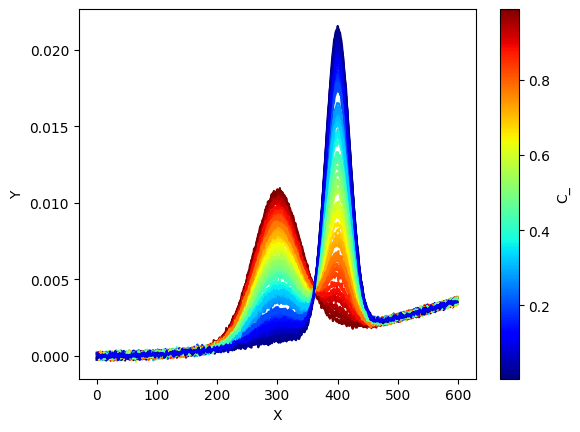

In [3]:
true_sig = np.dot(C_true,S_true)
Obs = np.dot(C_true,S_true) + E_ + np.random.randn(nb_samples,len(x))*1e-4

# prepare figure
ax = plt.subplot()

# norm is a class which, when called, can normalize data into the
# [0.0, 1.0] interval.
norm = matplotlib.colors.Normalize(
    vmin=np.min(C_),
    vmax=np.max(C_))

# choose a colormap
c_m = matplotlib.cm.jet

# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])

# plotting spectra
# calling the ScalarMappable that was initialised with c_m and norm
for i in range(C_.shape[0]):
    plt.plot(x,
             Obs[i,:].T,
             color=s_m.to_rgba(C_[i]))

# we plot the colorbar, using again our
# ScalarMappable
c_bar = plt.colorbar(s_m, ax=ax)
c_bar.set_label(r"C_")

plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Baseline fit

We will use the rampy.baseline function with the gcvspline option, without specifying the smoothing coefficient. It will be automatically determined using the GCV algorithm.

We first create the array to store baseline-corrected spectra

In [4]:
Obs_corr = np.ones(Obs.shape)
print(Obs_corr.shape)

(100, 600)


We define regions of interest ROI where the baseline will fit the signals. From the previous figure, this is clear that it should be between 0 and 100, and 500 and 600.

In [5]:
ROI = np.array([[0.,100.],[500.,600.]])
print(ROI)

[[  0. 100.]
 [500. 600.]]


Then we loop to save the baseline corrected data in this array.

In [6]:
for i in range(nb_samples):
    sig_corr, bas_, = rp.baseline(x, Obs[i,:].T, method="gcvspline", roi=ROI)
    Obs_corr[i,:] = sig_corr.reshape(1,-1)


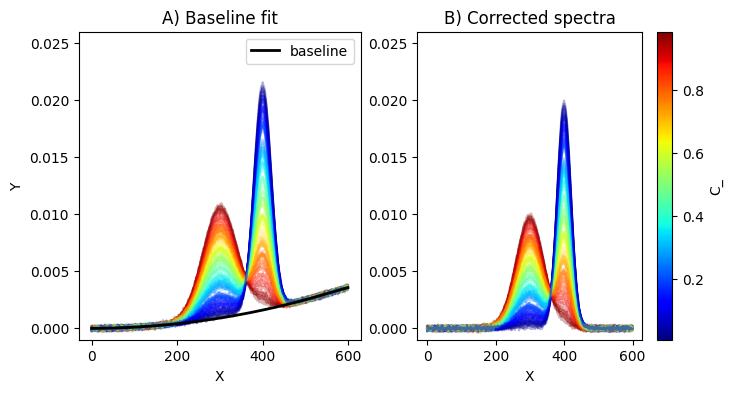

<Figure size 640x480 with 0 Axes>

In [7]:
# plotting spectra
# calling the ScalarMappable that was initialised with c_m and norm

plt.figure(figsize=(8,4))
ax1 = plt.subplot(1,2,1)

for i in range(C_.shape[0]):
    plt.plot(x,
             Obs[i,:].T,
             color=s_m.to_rgba(C_[i]), alpha=0.3)

plt.plot(x,bas_,"k-",linewidth=2.0,label="baseline")

plt.xlabel('X')
plt.ylabel('Y')
plt.ylim(-0.001,0.026)
plt.legend()
plt.title("A) Baseline fit")

ax2 = plt.subplot(1,2,2)

for i in range(C_.shape[0]):
    plt.plot(x,
             Obs_corr[i,:].T,
             color=s_m.to_rgba(C_[i]), alpha=0.3)


c_bar = plt.colorbar(s_m, ax=ax2, )
c_bar.set_label(r"C_")

plt.xlabel('X')
plt.ylim(-0.001,0.026)
plt.title("B) Corrected spectra")
plt.show()
plt.tight_layout()


# Centroid determination

Now we can calculate the centroid of the signal. rampy.centroid calculates it as

`centroid = np.sum(y_/np.sum(y_)*x)`

It accepts arrays of spectrum, organised as n points by m samples.

Smoothing can be done if wanted, by indicating `smoothing = True`. We will compare both in the following code.

A tweak is to prepare an array fo x with the same shape as y, and the good x values in each columns.

Furthermore, do not forget that arrays should be provided as n points by m samples. So use `.T` if needed to transpose your array. We need it below!

In [8]:
x_array = np.ones((len(x),nb_samples))
for i in range(nb_samples):
    x_array[:,i] = x

centroids_no_smooth = rp.centroid(x_array,Obs_corr.T)
centroids_smooth = rp.centroid(x_array,Obs_corr.T,smoothing=True)
centroids_true_sig = rp.centroid(x_array,true_sig.T,smoothing=True)

Now we can plot the centroids against the chemical ratio C_ for instance.

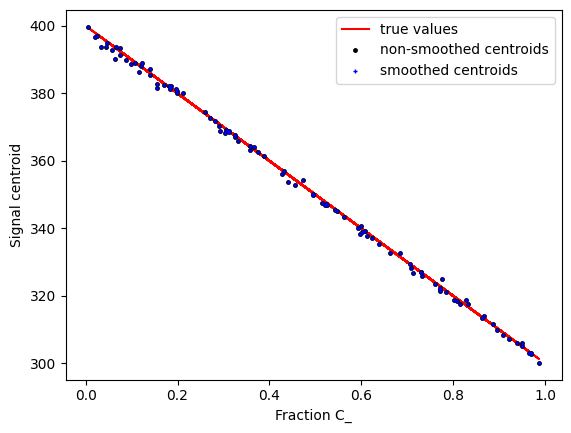

In [9]:
plt.figure()
plt.plot(C_,centroids_true_sig,"r-",markersize=3.,label="true values")
plt.plot(C_,centroids_no_smooth,"k.",markersize=5., label="non-smoothed centroids")
plt.plot(C_,centroids_smooth,"b+",markersize=3., label="smoothed centroids")
plt.xlabel("Fraction C_")
plt.ylabel("Signal centroid")
plt.legend()